In [2]:
import tensorflow as tf
import os
import subprocess
#import tensorflow_io as tfio
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import IPython.display as display

# Convert webm to .wav file
Using the FFmpeg application, I ran a subprocess to iteratively convert the .webm files to .wav files

In [2]:
# directory = os.fsencode('C:\\Users\\alexa\\DS6050\\Data')
# path = 'C:\\Users\\alexa\\DS6050\\Data'
# for file in os.listdir(directory):
#     filename = os.fsdecode(file)
#     if filename.endswith('webm'):
#         subprocess.run(['FFmpeg','-i',os.path.join(path,filename),'C:/Users/alexa/DS6050/Data/'+filename+'.wav'])
        

Then I removed the .webm from the file name

In [3]:
# directory = os.fsencode('C:\\Users\\alexa\\DS6050\\Data')
# path = 'C:\\Users\\alexa\\DS6050\\Data'
# files = []
# for file in os.listdir(directory):
#     filename = os.fsdecode(file)
#     if filename.endswith('wav'):
#         os.rename(os.path.join(path,filename),os.path.join(path,filename.replace('.webm','')))
#         files.append(filename)

Get the status of the patient for a corresponding audio file. For now, just get the healthy and COVID-19 cases. 

In [4]:
label_df = pd.read_csv('C:/Users/alexa/DS6050/Data/metadata_compiled.csv')[['uuid','status']]

Break out the labels and audio files into healthy and covid. 

In [5]:
path = 'C:\\Users\\alexa\\DS6050\\Data'
healthy = list(label_df.loc[label_df['status']=='healthy'].uuid)
healthy = [path + '\\' + x + '.wav' for x in healthy]
covid = list(label_df.loc[label_df['status']=='COVID-19'].uuid)
covid = [path + '\\' + x + '.wav' for x in covid]

Convert both lists to list_files objects. 

Read in the sound data from the wav files.

In [6]:
def load_wav(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    return wav, sample_rate

In [7]:
def preprocess(path, label):
    # call the wav data load function
    wav, sample_rate = load_wav(path)
    # Do the short-time Fourier Transform. 
    spectrogram = tf.signal.stft(wav, frame_length = 2048, frame_step = 512)
    # take absolute value of spectrogram
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    spectrogram = tf.image.resize(spectrogram,[512,512])
    rgb_spectrogram = tf.image.grayscale_to_rgb(spectrogram, name=None)
    rgb_spectrogram = tf.cast(rgb_spectrogram, dtype='uint8')
    return rgb_spectrogram, label

In [8]:
# filepath,label=covid.shuffle(buffer_size=len(covid)).as_numpy_iterator().next()
# spectrogram,label=preprocess(filepath,label)

In [40]:
  with tf.io.TFRecordWriter(path = 'C:\\Users\\alexa\\DS6050\\TFRecord\\covid.tfrecords') as file_writer:
    for file in covid:
        label = 1
        try:
            x, y = preprocess(file, label)
        except:
            continue

        record_bytes = tf.train.Example(features=tf.train.Features(feature={
        "image_raw": tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(x).numpy()])
    ),
        "covid": tf.train.Feature(float_list=tf.train.FloatList(value=[y])),
        })).SerializeToString()
        file_writer.write(record_bytes)


In [3]:
filenames = ['C:\\Users\\alexa\\DS6050\\TFRecord\\covid.tfrecords']
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [4]:
feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'covid': tf.io.FixedLenFeature([], tf.float32, default_value=0),
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

In [5]:
parsed_dataset = raw_dataset.map(_parse_function)

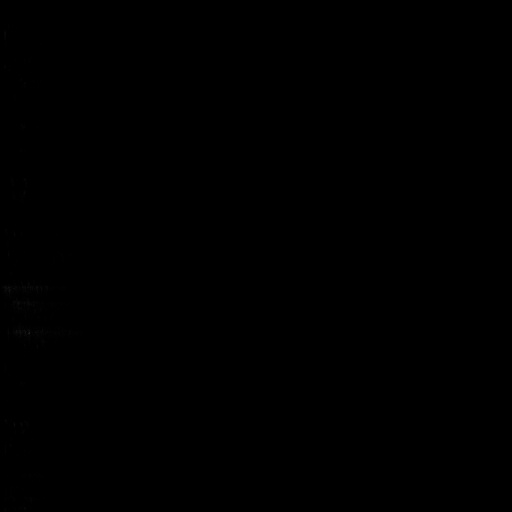

tf.Tensor(1.0, shape=(), dtype=float32)


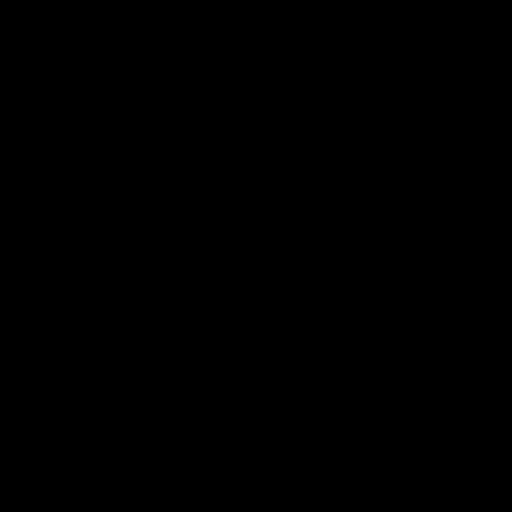

tf.Tensor(1.0, shape=(), dtype=float32)


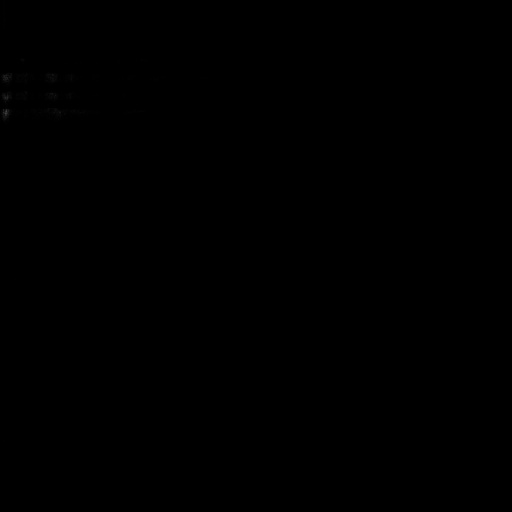

tf.Tensor(1.0, shape=(), dtype=float32)


In [6]:
for image_features in parsed_dataset.take(3):
    image_raw = image_features['image_raw'].numpy()
    display.display(display.Image(data=image_raw))
    print(image_features['covid'])

Now do the same thing for the non-covid files

In [51]:
  with tf.io.TFRecordWriter(path = 'C:\\Users\\alexa\\DS6050\\TFRecord\\healthy.tfrecords') as file_writer:
    for file in healthy:
        label = 0
        try:
            x, y = preprocess(file, label)
        except:
            continue

        record_bytes = tf.train.Example(features=tf.train.Features(feature={
        "image_raw": tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(x).numpy()])
    ),
        "covid": tf.train.Feature(float_list=tf.train.FloatList(value=[y])),
        })).SerializeToString()
        file_writer.write(record_bytes)


In [7]:
filenames = ['C:\\Users\\alexa\\DS6050\\TFRecord\\healthy.tfrecords']
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [8]:
feature_description = {
    'image_raw': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'covid': tf.io.FixedLenFeature([], tf.float32, default_value=0),
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

In [9]:
parsed_dataset = raw_dataset.map(_parse_function)

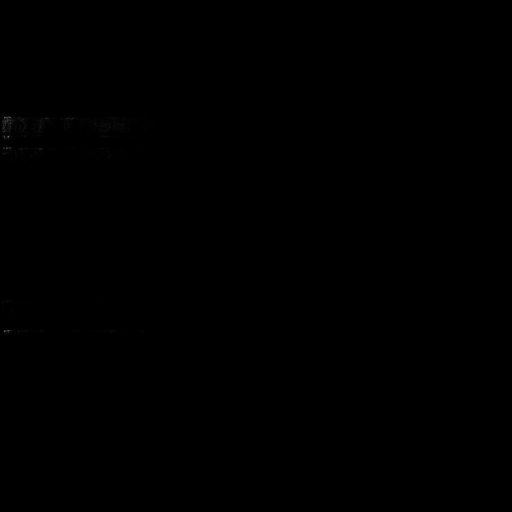

tf.Tensor(0.0, shape=(), dtype=float32)


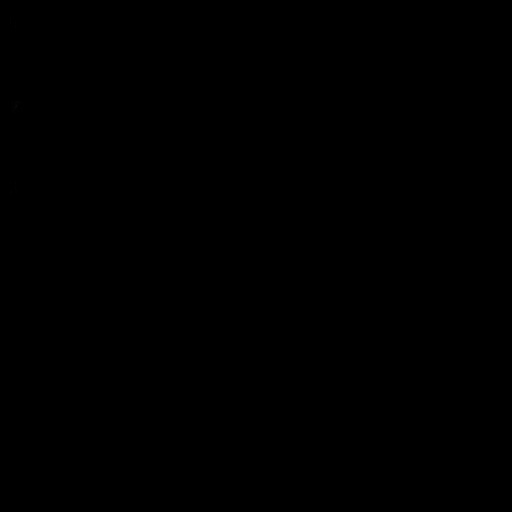

tf.Tensor(0.0, shape=(), dtype=float32)


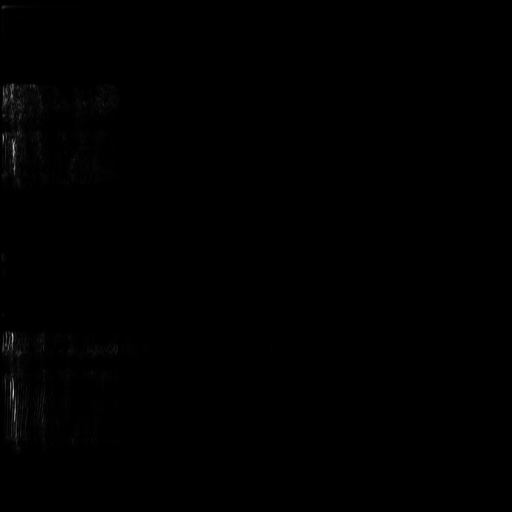

tf.Tensor(0.0, shape=(), dtype=float32)


In [20]:
for image_features in parsed_dataset.take(3):
    image_raw = image_features['image_raw'].numpy()
    display.display(display.Image(data=image_raw))
    print(image_features['covid'])


In [21]:
image = tf.io.decode_image(
image_raw
)

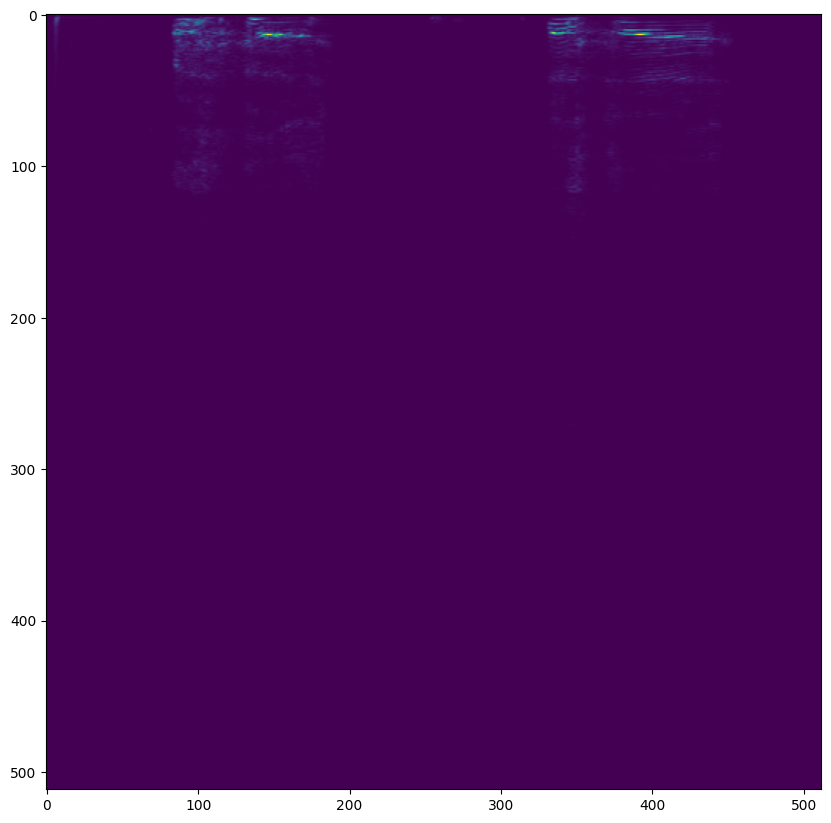

In [22]:
plt.figure(figsize=(10,20))
plt.imshow(tf.transpose(image)[0])
plt.show()